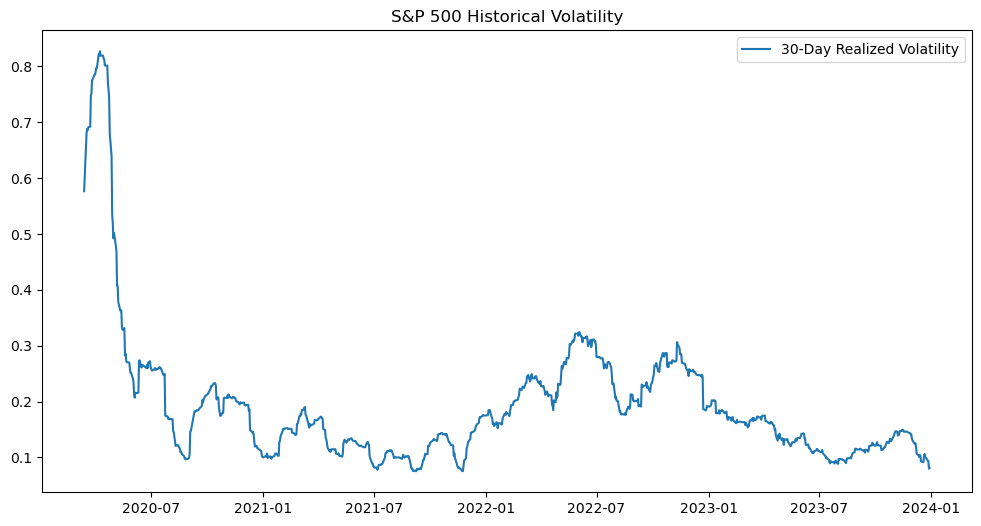

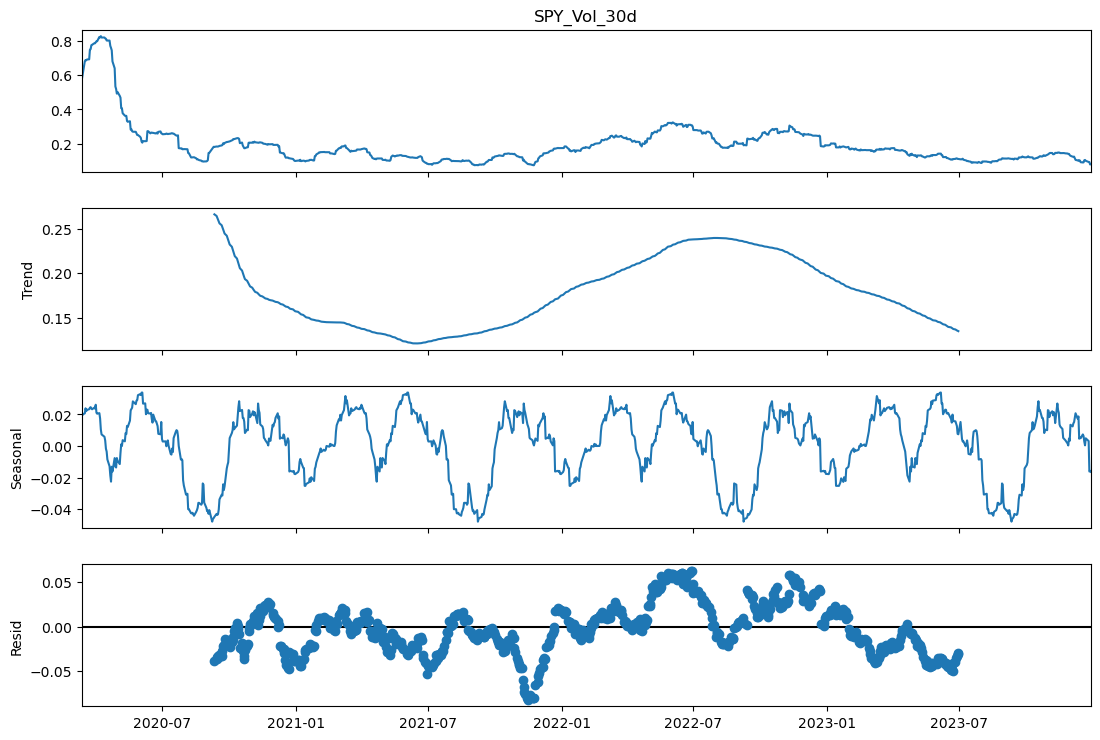

------------------------------------------------
running Augmented Dickey-Fuller Test...
ADF Statistic: -6.166087761285011
p-value: 6.98456283657724e-08
✅ Conclusion: Data is STATIONARY (Ready for Modeling)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Load Data
df = pd.read_csv('../data/processed/market_features.csv', index_col=0, parse_dates=True)

# We will model Volatility (SPY_Vol_30d) because Risk Managers care about Risk, not Price.
target_series = df['SPY_Vol_30d'].dropna()

# 1. Visualize the Data
plt.figure(figsize=(12, 6))
plt.plot(target_series, label='30-Day Realized Volatility')
plt.title("S&P 500 Historical Volatility")
plt.legend()
plt.show()

# 2. Decompose the Series (Trend vs. Seasonality vs. Noise)
# We use 'additive' model because volatility doesn't grow exponentially with time
decomposition = seasonal_decompose(target_series, model='additive', period=252) # 252 trading days
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.show()

# 3. The Augmented Dickey-Fuller Test (The "Stationarity Check")
print("------------------------------------------------")
print("running Augmented Dickey-Fuller Test...")
result = adfuller(target_series)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

if result[1] < 0.05:
    print("✅ Conclusion: Data is STATIONARY (Ready for Modeling)")
else:
    print("⚠️ Conclusion: Data is NON-STATIONARY (Needs Differencing)")

Training on 765 days, Testing on 192 days.


/Users/avniderashree/miniconda3/envs/quant_env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/avniderashree/miniconda3/envs/quant_env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/avniderashree/miniconda3/envs/quant_env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:            SPY_Vol_30d   No. Observations:                  765
Model:                 ARIMA(5, 1, 0)   Log Likelihood                2442.826
Date:                Thu, 25 Dec 2025   AIC                          -4873.651
Time:                        22:51:33   BIC                          -4845.820
Sample:                             0   HQIC                         -4862.936
                                - 765                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0956      0.037      2.618      0.009       0.024       0.167
ar.L2          0.2444      0.024     10.170      0.000       0.197       0.292
ar.L3          0.0518      0.026      1.971      0.0

/Users/avniderashree/miniconda3/envs/quant_env/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/avniderashree/miniconda3/envs/quant_env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/avniderashree/miniconda3/envs/quant_env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


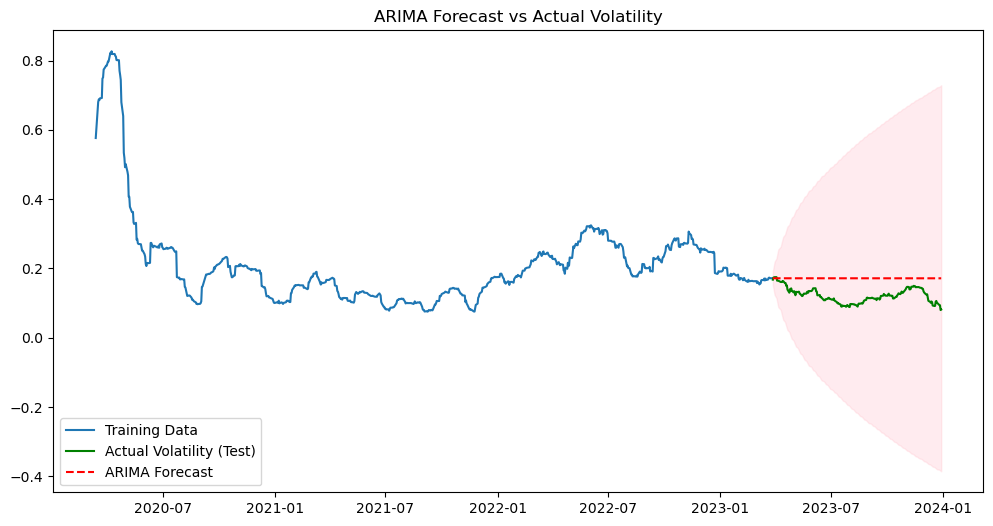

In [3]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# 1. Split Data (Train vs Test)
# IN FINANCE, NEVER SHUFFLE DATA. Always split by time.
train_size = int(len(target_series) * 0.8)
train, test = target_series[0:train_size], target_series[train_size:]

print(f"Training on {len(train)} days, Testing on {len(test)} days.")

# 2. Build ARIMA Model
# Order (p,d,q) = (5, 1, 0) -> Autoregressive(5), Differencing(1)
model = ARIMA(train, order=(5,1,0))
model_fit = model.fit()

# 3. Print Summary (Look at P>|z| column - should be < 0.05 for significance)
print(model_fit.summary())

# 4. Forecast
# We forecast the entire 'test' period
forecast_result = model_fit.get_forecast(steps=len(test))
forecast_values = forecast_result.predicted_mean
conf_int = forecast_result.conf_int() # Confidence Intervals (The "Cone of Uncertainty")

# 5. Plotting the Result
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual Volatility (Test)', color='green')
plt.plot(test.index, forecast_values, label='ARIMA Forecast', color='red', linestyle='--')
plt.fill_between(test.index, conf_int.iloc[:,0], conf_int.iloc[:,1], color='pink', alpha=0.3)

plt.title("ARIMA Forecast vs Actual Volatility")
plt.legend()
plt.show()

In [4]:
mse = mean_squared_error(test, forecast_values)
rmse = np.sqrt(mse)

print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Volatility in Test Set: {test.mean():.4f}")

# Contextualize
error_pct = (rmse / test.mean()) * 100
print(f"The model is off by approximately {error_pct:.2f}% on average.")

Root Mean Squared Error (RMSE): 0.0538
Mean Volatility in Test Set: 0.1222
The model is off by approximately 44.01% on average.
